<a href="https://colab.research.google.com/github/jdcast/dl-final-project/blob/main/UNet_CPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## UNet + CPC Encoders
- modifieds UNet by combining encoders from the CPC image sequences model and CPC kinematics model in z-space (encoder output) at bottleneck of UNet
- allows for inference of modified UNet
- allows for finetuning of modified UNet
- CPC images sequences model reference: https://colab.research.google.com/drive/1XeGnR55SgTahjv4aVRiIgKvlShN_uA99#scrollTo=F4-53HZ7mgOx&uniqifier=1
- CPC kinematics model reference: https://colab.research.google.com/drive/1b3PU0v3nPans-MyjKXCcylz0fWFZQilT?usp=sharing
- UNet model reference: https://colab.research.google.com/drive/1FtT3_qF5jcqHDazesrxkdaOtd2mvimdl#scrollTo=IHlVYMbH0ZGk

## Imports

In [1]:
import os
import pdb
import time
import random

%matplotlib inline
import torch as T
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from random import randrange
from random import choice
from random import uniform
from torchsummary import summary
from torchvision.models.inception import inception_v3
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as functional
import torchvision.transforms.functional as TF
from scipy.stats import entropy
from scipy.stats import iqr
from tqdm import tqdm
import copy

from skimage import io

import itertools
# For loading .mat file
import scipy.io

torch.manual_seed(0); #you may want to make use of this in various cells for reproducability
gpu_boole = torch.cuda.is_available()
print("GPU Available: {}".format(gpu_boole))

GPU Available: True


## Mount Google Drive

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Mounted at /content/gdrive


# Dataset

## Data Directory

In [3]:
# Image.open('/content/gdrive/My Drive/Colab Notebooks/CPC/lena.jpeg')

In [4]:
#address of data in google drive 
data_dir = '/content/gdrive/MyDrive/JHU/Courses/Deep Learning/final_project/Synthetic_MICCAI2020_dataset'

## Display Sample of Data

(538, 701, 3)


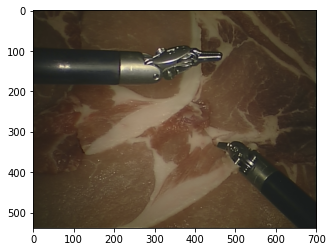

In [5]:
test_img_path = os.path.join(data_dir, "Video_01/images/000.png")
test_img = io.imread(test_img_path)
plt.imshow(test_img)
print(test_img.shape) #original img dimension

In [6]:
mat = scipy.io.loadmat(os.path.join(data_dir, 'Video_01/kinematic.mat'))
print(mat.keys())
mat

dict_keys(['__header__', '__version__', '__globals__', 'jaw_values1', 'jaw_values3', 'joint_values1', 'joint_values3', 'ecm_values'])


{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Feb 29 11:59:49 2020',
 '__version__': '1.0',
 'ecm_values': array([[-0.08814785, -0.08814785, -0.08814785, ..., -0.08814785,
         -0.08814785, -0.08814785],
        [-0.46083237, -0.46083237, -0.46083237, ..., -0.46083237,
         -0.46083237, -0.46083237],
        [ 0.17415773,  0.17415773,  0.17415773, ...,  0.17415773,
          0.17415773,  0.17415773],
        [ 0.60085643,  0.60085643,  0.60085643, ...,  0.60085643,
          0.60085643,  0.60085643]]),
 'jaw_values1': array([[-0.16308299, -0.1631538 , -0.16308299, ...,  0.0143751 ,
          0.01472916,  0.01479998]]),
 'jaw_values3': array([[-0.16824439, -0.16824439, -0.17102124, ...,  0.06876785,
          0.07105467,  0.07350483]]),
 'joint_values1': array([[ 0.48887216,  0.4939151 ,  0.4958149 , ...,  0.65067114,
          0.65058619,  0.65053213],
        [-0.26129094, -0.25934482, -0.25895868, ..., -0.18256541,
         -0.18

## Dataloader Architecture
 - returns sequences of image sequences
 - return shape: (terms+predict_terms, c, frames, h, w)

### Video dataloader

In [7]:
class ImageDataset(Dataset):
    """
    Image Dataset
    """

    def __init__(self, data_dir, op, frame = 10, transform=False, occlusion=False):
        """
        Args:
            input_dir: input data path to images and masks
        """
        assert frame > 1, 'number of frames should be an integer greater than 1'

        self.frame = frame
        self.op = op # specify train or test 
        self.data_dir = data_dir
        self.transform = transform
        if occlusion:
          assert self.frame > 9, 'number of frames should be greater than 9 for occlusion to work'
        self.occlusion = occlusion
        self.occ_frames = 4 # Number of frames to occlude.
        self.occ_box_size = 50
        self.mask_num = 2 # Only 2 output class labels.
        self.h = 256
        self.w = 320
        self.mask_value = {0:0, 1:255}
        
        try:
          if self.op == 'train':
              self.len = 300 * 8 // frame # Videos 1-8 with 300 frames each.
          elif self.op == 'val':
              self.len = 300 * 2 // frame # Videos 9-10.
          elif self.op == 'test':
              self.len = 300 * 4 // frame # Videos 11-14.
        except ValueError:
          print ('op should be train or test.')
    
    
    def __len__(self):
        """
          for training: using videos from 01-08 each with 300 pics (14 * 300 img in total)
          for val: using videos from 09-10 each with 300 pics (6 * 300 img in total)
          for testing: using videos from 11-15 each with 300 pics (6 * 300 img in total)
        """
        return self.len

    def __getitem__(self, idx):
        """
          returning corresponding img and mask from dataset folder 
        """

        video_id = (idx * self.frame) // 300 + 1 #returning the number part of video's name str (i.e. "Video_01"'s '01')

        if self.op == 'train':
            video_name = str(video_id).zfill(2) 
        elif self.op == 'val':
            video_id = (idx * self.frame) // 300 + 9
            video_name = str(video_id).zfill(2)
        else:
            video_id = (idx * self.frame) // 300 + 11
            video_name = str(video_id).zfill(2)
        
        img_dir = os.path.join(self.data_dir, "Video_" + video_name, "images")
        mask_dir = os.path.join(self.data_dir, "Video_" + video_name, "ground_truth")

        frames = [(idx * self.frame + i) % 300 for i in range(self.frame)]
        # start = np.random.randint(100)
        # interval = np.random.randint(5, 10)
        # print (start, interval)
        # frames = [start for _ in range(self.frame)]

        img, mask = torch.zeros((3, self.frame, self.h, self.w)), torch.zeros((2, len(frames), 256, 320))

        if self.occlusion:
          start = -1
          if np.random.random() > 0.6:
            start = np.random.randint(self.frame - self.occ_frames)

        for i in range(self.frame):

            img_name = os.path.join(img_dir, str(frames[i]).zfill(3) + ".png")
            mask_name = os.path.join(mask_dir, str(frames[i]).zfill(3) + '.png')
            
            img_next = Image.open(img_name)
            mask_next = Image.open(mask_name)

            img_next = TF.resize(img_next, (self.h, self.w), interpolation=TF.InterpolationMode.NEAREST)
            mask_next = TF.resize(mask_next, (self.h, self.w), interpolation=TF.InterpolationMode.NEAREST)
            
            # Apply data augmentations, if any.
            if self.transform:
                img_next, mask_next = self.augment(img_next, mask_next)

            # occlusion
            if self.occlusion and i >= start and i < start + self.occ_frames:
                img_next, mask_next = self.occlude(img_next, mask_next)
            
            mask_next = np.array(mask_next)
            
            # Convert grey-scale label to one-hot encoding
            new_mask = np.zeros((self.h, self.w, self.mask_num))
            for idx in range(self.mask_num):
                new_mask[:, :, idx] = mask_next[:, :, 0] == self.mask_value[idx]

            # Transform to tensor
            img_next = TF.to_tensor(img_next)
            mask_next = TF.to_tensor(new_mask)
            
            img[:, i, :, :] = img_next
            mask[:, i, :, :] = mask_next

        # Load kinematic info
        kin_dir = os.path.join(self.data_dir, "Video_" + video_name)
        kin_name = kin_dir + "/kinematic.mat"
        kin_mat = scipy.io.loadmat(kin_name)
        ecm_values = torch.Tensor(kin_mat['ecm_values'])
        joint_values1 = torch.Tensor(kin_mat['joint_values1'])
        jaw_values1 = torch.Tensor(kin_mat['jaw_values1'])
        joint_values3 = torch.Tensor(kin_mat['joint_values3'])
        jaw_values3 = torch.Tensor(kin_mat['jaw_values1'])

        kin_all = torch.cat((ecm_values, joint_values1, jaw_values1, joint_values3, jaw_values3), 0)
        # It has 1500 time frames of kinematic for each video, but for the comparison with the original paper,
        # which says "collect every 150 ms to avoid redundance", i.e. reduce to the same frames/sec as the image data,
        # we also reduce the amount of kinematic data by slicing it at the step = 5
        kin_sampled = kin_all[:, 1:1500:5]
        kin_framed = kin_sampled[:, frames]
        kin = kin_framed

        return img, mask, kin

    def augment(self, img, mask):

        
        if np.random.random() > 0.5:

            # # Random horizontal flipping
            # if np.random.random() > 0.5:
            #     img = TF.hflip(img)
            #     mask = TF.hflip(mask)

            # # Random vertical flipping
            # if np.random.random() > 0.5:
            #     img = TF.vflip(img)
            #     mask = TF.vflip(mask)

            # Random brightness change
            if np.random.random() > 0.5:
                img = TF.adjust_brightness(img, np.random.uniform(0.5, 2))

            # Random contrast change
            if np.random.random() > 0.75:
                img = TF.adjust_contrast(img, np.random.uniform(0.5, 2))
            
            # Random hue change
            if np.random.random() > 0.8:
                img = TF.adjust_hue(img, np.random.uniform(-0.3, 0.3))

            # # Random equalize
            # if np.random.random() > 0.9:
            #     img = TF.equalize(img)

            # Random gaussian blur
            if np.random.random() > 0.9:
                img = TF.gaussian_blur(img, [3, 3])
        
        return img, mask

    def occlude(self, img, mask):

        img = np.array(img)
        tool_removed_img = np.where(mask, 0, img)

        min_size = min(self.h, self.w)
        if self.h == min_size:
          coord_h_low, coord_h_high = self.h // 2 - self.h // 3, self.h // 2 + self.h // 3
          coord_w_low, coord_w_high = self.w // 2 - self.h // 3, self.w // 2 + self.h // 3
          slack = self.h - coord_h_high
        else:
          coord_h_low, coord_h_high = self.h // 2 - self.w // 3, self.h // 2 + self.w // 3
          coord_w_low, coord_w_high = self.w // 2 - self.w // 3, self.w // 2 + self.w // 3
          slack = self.w - coord_w_high


        center_img = img[coord_h_low:coord_h_high, coord_w_low:coord_w_high, :]
        center_tool_removed_img = tool_removed_img[coord_h_low:coord_h_high, coord_w_low:coord_w_high, :]
        
        new_center = np.zeros(center_img.shape)
        
        # Flip
        flip = np.random.randint(3)
        if not flip: # horizontal_flip
          flipped_img = np.flip(img, 0)
          flipped_tool_removed_img = np.flip(tool_removed_img, 0)
        elif flip == 1: # vertical flip
          flipped_img = np.flip(img, 1)
          flipped_tool_removed_img = np.flip(tool_removed_img, 1)
        else: # both
          flipped_img = np.flip(img, (0, 1))
          flipped_tool_removed_img = np.flip(tool_removed_img, (0, 1))

        # Rotated center image to paste from.
        rot_center_img = np.rot90(center_img, 1, (0, 1))

        # Translate
        delta = np.random.randint(slack // 4, slack // 2)
        direction = np.random.randint(4)
        if not direction: # Towards bottom right
          coord_h_lowt, coord_w_lowt, coord_h_hight, coord_w_hight = coord_h_low + delta, coord_w_low + delta, coord_h_high + delta, coord_w_high + delta
        elif direction == 1: # Towards top right
          coord_h_lowt, coord_w_lowt, coord_h_hight, coord_w_hight = coord_h_low - delta, coord_w_low + delta, coord_h_high - delta, coord_w_high + delta
        elif direction == 1: # Towards bottom left
          coord_h_lowt, coord_w_lowt, coord_h_hight, coord_w_hight = coord_h_low + delta, coord_w_low - delta, coord_h_high + delta, coord_w_high - delta
        else: # Towards top left
          coord_h_lowt, coord_w_lowt, coord_h_hight, coord_w_hight = coord_h_low - delta, coord_w_low - delta, coord_h_high - delta, coord_w_high - delta

        transformed_center_img = flipped_img[coord_h_lowt:coord_h_hight, coord_w_lowt:coord_w_hight, :]
        transformed_center_tool_removed_img = flipped_tool_removed_img[coord_h_lowt:coord_h_hight, coord_w_lowt:coord_w_hight, :]

        center_new = np.where(center_tool_removed_img == transformed_center_tool_removed_img, rot_center_img, center_img)
        img[coord_h_low:coord_h_high, coord_w_low:coord_w_high, :] = center_new
        
        return img, mask

## Test Dataloaders

### Video dataloader test

torch.Size([5, 3, 10, 256, 320]) torch.Size([5, 2, 10, 256, 320]) torch.Size([5, 18, 10])


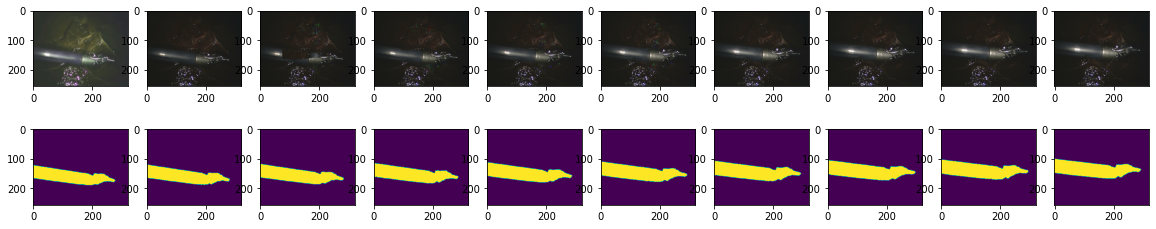

In [8]:
batch_size = 5

train_dataset = ImageDataset(data_dir, op='train', transform=True, occlusion=True)
val_dataset = ImageDataset(data_dir, op='val', transform=False, occlusion=False)
test_dataset = ImageDataset(data_dir, op='test', transform=False, occlusion=False)

train_dataloader = DataLoader(train_dataset,  batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

img, mask, kin = next(iter(train_dataloader))
print(img.shape, mask.shape, kin.shape)
fig = plt.figure(figsize=(20, 4))
columns = 10
rows = 2

for i in range(rows):
  for j in range(columns):
    if i == 0:
      image = torch.permute(img[0, :, j, :, :], (1, 2, 0)).cpu().numpy()
      fig.add_subplot(rows, columns, i * columns + j + 1)
      plt.imshow(image)
    else:
      image = torch.argmax(mask[0], dim=0)[j].cpu().numpy()
      fig.add_subplot(rows, columns, i * columns + j + 1)
      plt.imshow(image)

plt.show()

# Dice Score/Loss

In [9]:
def dice_score_batch(prediction, target, n_classes):
    '''
      compute the mean dice score for a single batch of frames

      Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
      Args:
          prediction (tensor): predictied labels of the batch
          target (tensor): ground truth of the batch
          n_classes (int): number of classes
    
      Returns:
          m_dice (float): Mean dice score over classes over the batch
    '''
    b, d, _, _ = target.shape

    dice_classes = torch.zeros((b, d, n_classes))
    TP = torch.zeros((b, d, n_classes))
    FP = torch.zeros((b, d, n_classes))
    FN = torch.zeros((b, d, n_classes))
    
    corrects = prediction == target
    incorrects = prediction != target
    
    for k in range(b):
      for j in range(d):
        for cl in range(n_classes):
            p_cl = (prediction == cl)[k][j]
            t_cl = (target == cl)[k][j]
            TP[k][j][cl] = torch.count_nonzero(torch.where(p_cl, corrects[k][j], False))
            FP[k][j][cl] = torch.count_nonzero(torch.where(p_cl, incorrects[k][j], False))
            FN[k][j][cl] = torch.count_nonzero(torch.where(t_cl, incorrects[k][j], False))
    
    for k in range(b):
      for j in range(d):
        for cl in range(n_classes):
            if FP[k][j][cl] == 0 and FN[k][j][cl] == 0:
                dice_classes[k][j][cl] = 1
            else:
                dice_classes[k][j][cl] = 2 * TP[k][j][cl] / (TP[k][j][cl] + FP[k][j][cl] + TP[k][j][cl] + FN[k][j][cl])
    
    return dice_classes.mean(dim=-1)



def dice_score_dataset(model, dataloader, num_classes=2, use_gpu=True):
    """
    Compute the mean dice score on a set of data.
    
    Note that multiclass dice score can be defined as the mean over classes of binary
    dice score. Dice score is computed per image. Mean dice score over the dataset is the dice
    score averaged across all images.
    
    Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
     
    Args:
        model (UNET class): Your trained model
        dataloader (DataLoader): Dataset for evaluation
        num_classes (int): Number of classes
    
    Returns:
        m_dice (float): Mean dice score over the input dataset
    """
    
    ## Number of Batches and Cache over Dataset 
    n_batches = len(dataloader)
    scores = None
    
    ## Evaluate
    model.eval()
    for data in dataloader:
        ## Format Data
        img, target, kin = data
        if use_gpu:
            img = img.cuda()
            target = target.cuda()
            kin = kin.cuda()
        ## Make Predictions
        out = model(img, kin)
        n_classes = out.shape[1]
        prediction = torch.argmax(out, dim = 1)
        target = torch.argmax(target, dim = 1)
        b, d, _, _ = prediction.shape
        score_batch = iou_score_batch(prediction, target, n_classes)
        if i == 0:
          scores = score_batch.flatten()
        else:
          scores = torch.cat((score_batch.flatten(), scores))
    ## Average Dice Score Over Images
    m_dice = scores
    return m_dice

def iou_score_batch(prediction, target, n_classes):
    '''
      compute the mean iou score for a single batch of frames

      Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
      Args:
          prediction (tensor): predictied labels of the batch
          target (tensor): ground truth of the batch
          n_classes (int): number of classes
    
      Returns:
          m_iou (float): Mean iou score over classes over the batch
    '''
    b, d, _, _ = target.shape

    iou_classes = torch.zeros((b, d, n_classes))
    TP = torch.zeros((b, d, n_classes))
    FP = torch.zeros((b, d, n_classes))
    FN = torch.zeros((b, d, n_classes))
    
    corrects = prediction == target
    incorrects = prediction != target
    
    for k in range(b):
      for j in range(d):
        for cl in range(n_classes):
            p_cl = (prediction == cl)[k][j]
            t_cl = (target == cl)[k][j]
            TP[k][j][cl] = torch.count_nonzero(torch.where(p_cl, corrects[k][j], False))
            FP[k][j][cl] = torch.count_nonzero(torch.where(p_cl, incorrects[k][j], False))
            FN[k][j][cl] = torch.count_nonzero(torch.where(t_cl, incorrects[k][j], False))
    
    for k in range(b):
      for j in range(d):
        for cl in range(n_classes):
            if FP[k][j][cl] == 0 and FN[k][j][cl] == 0:
                iou_classes[k][j][cl] = 1
            else:
                iou_classes[k][j][cl] = TP[k][j][cl] / (TP[k][j][cl] + FP[k][j][cl] + FN[k][j][cl])
    
    return iou_classes.mean(dim=-1)

def iou_score_dataset(model, dataloader, num_classes=2, use_gpu=True):
    """
    Compute the mean iou score on a set of data.
    
    Note that multiclass iou score can be defined as the mean over classes of binary
    iou score. iou score is computed per image. Mean iou score over the dataset is the iou
    score averaged across all images.
    
    Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
     
    Args:
        model (UNET class): Your trained model
        dataloader (DataLoader): Dataset for evaluation
        num_classes (int): Number of classes
    
    Returns:
        m_iou (float): Mean iou score over the input dataset
    """
    
    ## Number of Batches and Cache over Dataset 
    n_batches = len(dataloader)
    scores = None
    
    ## Evaluate
    model.eval()
    for i, data in enumerate(dataloader):
        img, target, kin = data
        if use_gpu:
            img = img.cuda()
            target = target.cuda()
            kin = kin.cuda()
        ## Make Predictions
        out = model(img, kin)
        n_classes = out.shape[1]
        prediction = torch.argmax(out, dim = 1)
        target = torch.argmax(target, dim = 1)
        b, d, _, _ = prediction.shape
        score_batch = iou_score_batch(prediction, target, n_classes)
        if i == 0:
          scores = score_batch.flatten()
        else:
          scores = torch.cat((score_batch.flatten(), scores))
    ## Average iou Score Over Images
    m_iou = scores
    return m_iou


class DICELoss(nn.Module):
    def __init__(self):
        super(DICELoss, self).__init__()
        self.eps = 1e-8
        
    def forward(self, pred, target):
        # Expecting in the form [batch_size, channel, d, h, w]
        
        pred = functional.softmax(pred, dim=1)
        
        num = torch.sum(pred * target, dim=(1, 3, 4))
        den = torch.sum(pred**2 + target**2, dim=(1, 3, 4)) / 2
        
        return 1 - ((num + self.eps) / (den + self.eps)).mean()

# Models

## Encoder for CPC Image Sequences

### Define Architecture
- use encoder from 3D Vanilla UNet: https://colab.research.google.com/drive/1FtT3_qF5jcqHDazesrxkdaOtd2mvimdl#scrollTo=_kN-xXH00mey

In [10]:
# Encoder

## Functions for adding the convolution layer
def add_conv_stage(dim_in,
                   dim_out,
                   kernel_size=3,
                   stride=1,
                   padding='same',
                   bias=True,
                   useBN=True):
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv3d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm3d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv3d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm3d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv3d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv3d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )

def last_layer(dim_in,
               dim_out,
               kernel_size=3,
               stride=1,
               padding='same',
               bias=True,
               useBN=True):
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv3d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm3d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv3d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv3d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv3d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
        )

class cpc_images_encoder(nn.Module):
  def __init__(self, useBN=True):
    super(cpc_images_encoder, self).__init__()

    # Downgrade stages
    if useBN:
      self.conv1 = nn.Sequential(
        nn.Conv3d(3, 32, kernel_size=3, stride=(1, 2, 2), padding=1, bias=True),
        nn.BatchNorm3d(32),
        nn.LeakyReLU(0.1))
    else:
      self.conv1 = nn.Sequential(
        nn.Conv3d(3, 32, kernel_size=3, stride=(1, 2, 2), padding=1, bias=True),
        nn.LeakyReLU(0.1))
    
    self.conv2 = add_conv_stage(32, 64, useBN=useBN)
    self.conv3 = add_conv_stage(64, 128, useBN=useBN)
    self.conv4 = add_conv_stage(128, 256, useBN=useBN)
    self.last_layer = last_layer(256, 512, useBN=useBN)
    
    # Maxpool
    self.max_pool122 = nn.MaxPool3d(2, stride=(1, 2, 2))
    self.max_pool2 = nn.MaxPool3d(2)

    # weight initialization
    for m in self.modules():
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        if m.bias is not None:
          m.bias.data.zero_()
        torch.nn.init.kaiming_uniform_(m.weight.data)
        
  def forward(self, inputs):
    """
    Forward pass
    """
    conv1_out = self.conv1(inputs)
    conv2_out = self.conv2(self.max_pool2(conv1_out))
    conv3_out = self.conv3(self.max_pool122(conv2_out))
    conv4_out = self.conv4(self.max_pool2(conv3_out))
    out = self.last_layer(self.max_pool2(conv4_out))

    return out

### Load Pretrained Model

In [11]:
cpc_images_encoder_path = "/content/gdrive/MyDrive/JHU/Courses/Deep Learning/DL_Project/runs/cpc_3d_encoder/1651689411_116581/cpc_images_encoder.pth"
cpc_images_encoder_model = cpc_images_encoder()
checkpoint = T.load(cpc_images_encoder_path)
cpc_images_encoder_model.load_state_dict(checkpoint['model_state_dict'])

if gpu_boole:
  cpc_images_encoder_model = cpc_images_encoder_model.cuda()

cpc_images_encoder_model.eval()

cpc_images_encoder(
  (conv1): Sequential(
    (0): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (conv2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv3): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), pa

### Freeze Model

In [12]:
for child in cpc_images_encoder_model.children():
  for param in child.parameters():
    param.requires_grad = False

### Print Architecture

In [13]:
# image_shape = (512, 672)
image_shape = (256, 320)
frames_per_term = 10
# print(cpc_images_encoder_model)
summary(cpc_images_encoder_model, (3, frames_per_term, image_shape[0], image_shape[1])) # dataloader provides batches of shape: (batch_size, c, frames, h, w)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 32, 10, 128, 160]           2,624
       BatchNorm3d-2     [-1, 32, 10, 128, 160]              64
         LeakyReLU-3     [-1, 32, 10, 128, 160]               0
         MaxPool3d-4        [-1, 32, 5, 64, 80]               0
            Conv3d-5        [-1, 64, 5, 64, 80]          55,360
       BatchNorm3d-6        [-1, 64, 5, 64, 80]             128
         LeakyReLU-7        [-1, 64, 5, 64, 80]               0
            Conv3d-8        [-1, 64, 5, 64, 80]         110,656
       BatchNorm3d-9        [-1, 64, 5, 64, 80]             128
        LeakyReLU-10        [-1, 64, 5, 64, 80]               0
        MaxPool3d-11        [-1, 64, 4, 32, 40]               0
           Conv3d-12       [-1, 128, 4, 32, 40]         221,312
      BatchNorm3d-13       [-1, 128, 4, 32, 40]             256
        LeakyReLU-14       [-1, 128, 4,

## Encoder for CPC Kinematics

### Define Architecture
- TODO

In [14]:
# Encoder
# Uses linear layers for fully connected layers (i.e. not fully convolutional)

class cpc_kinematic_encoder(nn.Module):
    # initializers
    def __init__(self, input_channel, code_size):
        '''
        input_channel: 
            18, treat one value of one degree of freedom  of one joint/jaw/etc as one channel
        code_size:
            80, output size. It is (80, 1)
        '''
        super(cpc_kinematic_encoder, self).__init__()

        # convolution layers
        self.conv1 = nn.Conv1d(in_channels=input_channel, out_channels=8, kernel_size=1)
        
        # # fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=8*10, out_features=4)  # 10 is because we fix the frame per term as 10.
        self.bnorm5 = nn.BatchNorm1d(4)
        self.fc2 = nn.Linear(in_features=4, out_features=code_size)
 
        # activations
        self.leakyRelu = nn.LeakyReLU()

    # weight_init
    # def weight_init(self, mean, std):
    def weight_init(self):
        for m in self._modules:
            # normal_init(self._modules[m], mean, std)
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.ConvTranspose1d) or isinstance(m, nn.Linear):
                if m.bias is not None:
                    m.bias.data.zero_()
                torch.nn.init.kaiming_uniform_(m.weight.data)

    # forward method
    def forward(self, input):
      out = self.conv1(input) 
      out = self.leakyRelu(out)
      out = self.flatten(out)
      out = self.fc1(out)
      out = self.bnorm5(out)
      out = self.leakyRelu(out)
      out = self.fc2(out)
      return out

### Load Pretrained Model


In [15]:
cpc_kin_encoder_path = '/content/gdrive/MyDrive/JHU/Courses/Deep Learning/DL_Project/kinematic_CPC_3D_encoder/1651411214_2568586/cpc_kinematic_encoder.pth'
cpc_kinematic_encoder_model = cpc_kinematic_encoder(input_channel=18, code_size=80)
# cpc_kin_encoder_model.load_state_dict(torch.load(cpc_kin_encoder_path), strict=False)
checkpoint = T.load(cpc_kin_encoder_path)
cpc_kinematic_encoder_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### Freeze Model


In [16]:
for child in cpc_kinematic_encoder_model.children():
  for param in child.parameters():
    param.requires_grad = False

### Print Architecture


In [17]:
summary(cpc_kinematic_encoder_model.cuda(), (18, 10)) # 18 parameters as a data point, 1 channel, 10 time frames
print(cpc_kinematic_encoder_model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [-1, 8, 10]             152
         LeakyReLU-2                [-1, 8, 10]               0
           Flatten-3                   [-1, 80]               0
            Linear-4                    [-1, 4]             324
       BatchNorm1d-5                    [-1, 4]               8
         LeakyReLU-6                    [-1, 4]               0
            Linear-7                   [-1, 80]             400
Total params: 884
Trainable params: 0
Non-trainable params: 884
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------
cpc_kinematic_encoder(
  (conv1): Conv1d(18, 8, kernel_size=(1,), stride=(1,))
  (flatten): Flatten(start_dim=1, e

## UNet
- taken from here: https://colab.research.google.com/drive/1FtT3_qF5jcqHDazesrxkdaOtd2mvimdl#scrollTo=XJ4XVfL_UNdb
- z-space concatenated with CPC models

### Define Architecture

In [18]:
def add_bottleneck_conv_stage(dim_in,
                              dim_out,
                              kernel_size=3,
                              stride=1,
                              padding=1,
                              dilation=1,
                              bias=True,
                              useBN=True):
    """
    layer to mix concatenated bottleneck tensors
    """
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv3d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, dilation=1, bias=bias),
          nn.BatchNorm3d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv3d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, dilation=1, bias=bias),
          nn.ReLU()
        )

## Functions for adding the convolution layer
def add_conv_stage(dim_in,
                   dim_out,
                   kernel_size=3,
                   stride=1,
                   padding='same',
                   bias=True,
                   useBN=True):
    """
    
    """
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv3d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm3d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv3d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm3d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv3d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv3d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )

class Vanilla_UNet(nn.Module):
    def __init__(self, loss='dice', useBN=True):
        super(Vanilla_UNet, self).__init__()

        # Downgrade stages
        if useBN:
          self.conv1 = nn.Sequential(
            nn.Conv3d(3, 32, kernel_size=3, stride=(1, 2, 2), padding=1, bias=True),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(0.1))
        else:
          self.conv1 = nn.Sequential(
            nn.Conv3d(3, 32, kernel_size=3, stride=(1, 2, 2), padding=1, bias=True),
            nn.LeakyReLU(0.1))
        
        self.conv2 = add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = add_conv_stage(64, 128, useBN=useBN)
        self.conv4 = add_conv_stage(128, 256, useBN=useBN)
        self.conv5 = add_conv_stage(256, 512, useBN=useBN)

        # bottleneck tensor mixing layers
        self.conv_bneck_1 = add_bottleneck_conv_stage(1025, 512, useBN=useBN)

        # Conv layers for concat.
        self.cs1 = nn.Sequential(
            nn.Conv3d(32, 32, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(0.1))
        self.cs2 = nn.Sequential(
            nn.Conv3d(64, 64, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(0.1))
        self.cs3 = nn.Sequential(
            nn.Conv3d(128, 128, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.1))
        self.cs4 = nn.Sequential(
            nn.Conv3d(256, 256, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(256),
            nn.LeakyReLU(0.1))

        # Upgrade stages
        self.conv4m = add_conv_stage(512, 256, useBN=useBN)
        self.conv3m = add_conv_stage(256, 128, useBN=useBN)
        self.conv2m = add_conv_stage(128,  64, useBN=useBN)
        self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
        
        # Maxpool
        self.max_pool122 = nn.MaxPool3d(2, stride=(1, 2, 2))
        self.max_pool2 = nn.MaxPool3d(2)
        
        # Upsample layers
        self.upsample54 = nn.Sequential(
                    nn.Upsample(scale_factor=2),
                    nn.Conv3d(512, 256, kernel_size=3, padding='same', bias=True),
                    nn.ReLU())
        self.upsample43 = nn.Sequential(
                    nn.Upsample(scale_factor=2),
                    nn.Conv3d(256, 128, kernel_size=3, padding='same', bias=True),
                    nn.ReLU())
        self.upsample32 = nn.Sequential(
                    nn.Upsample(size=(5, 64, 80)),
                    nn.Conv3d(128, 64, kernel_size=3, padding='same', bias=True),
                    nn.ReLU())
        self.upsample21 = nn.Sequential(
                    nn.Upsample(scale_factor=2),
                    nn.Conv3d(64, 32, kernel_size=3, padding='same', bias=True),
                    nn.ReLU())
        
        self.upsample10 = nn.Sequential(
                    nn.Upsample(size=(10, 256, 320)),
                    nn.Conv3d(32, 16, kernel_size=3, padding='same', bias=True),
                    nn.BatchNorm3d(16),
                    nn.ReLU())


        # weight initialization
        # You can have your own weight intialization. This is just an example.
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()
                torch.nn.init.kaiming_uniform_(m.weight.data)

        # Final layer.
        self.conv_fin = nn.Conv3d(16, 2, 1)
        self.dice_loss = DICELoss()
        self.mse_loss = nn.MSELoss()
        self.loss = self.dice_loss
        if loss == 'mse':
          self.loss = self.mse_loss
        
    
    def forward(self, inputs_img, inputs_kin):

        """
        Forward pass
        """
        conv1_out = self.conv1(inputs_img)
        conv2_out = self.conv2(self.max_pool2(conv1_out))
        conv3_out = self.conv3(self.max_pool122(conv2_out))
        conv4_out = self.conv4(self.max_pool2(conv3_out))
        conv5_out = self.conv5(self.max_pool2(conv4_out))
        cs1_out = self.cs1(conv1_out)
        cs2_out = self.cs2(conv2_out)
        cs3_out = self.cs3(conv3_out)
        cs4_out = self.cs4(conv4_out)

        ## mix in CPC encoders at bottleneck

        # method 1 - concatenate cpc models' output (z-space) to unet bottleneck and mix with convolution
        #TODO add in cpc kinematics z_k
        z_i = cpc_images_encoder_model(inputs_img)
        z_k = cpc_kinematic_encoder_model(inputs_kin)
        zkk_reshape = z_k.reshape(z_k.shape[0], 8, 10)
        z_k = zkk_reshape.unsqueeze(1).unsqueeze(1)

        bottleneck = T.cat((conv5_out, z_i, z_k), 1)
        bottleneck = self.conv_bneck_1(bottleneck)
        
        # # method 2 - we simply average the tensors at the bottleneck
        # bottleneck = conv5_out.add(z_i)
        # bottleneck = T.div(bottleneck, 2) 
        # #TODO adjust denominator when CPC kinematics is added in

        # conv5m_out_ = torch.cat((self.upsample54(conv5_out), conv4_out), 1)
        conv5m_out_ = torch.cat((self.upsample54(bottleneck), cs4_out), 1)
        # conv5m_out_ = torch.cat((self.upsample54(conv5_out), cs4_out), 1)
        conv4m_out  = self.conv4m(conv5m_out_)

        # conv4m_out_ = torch.cat((self.upsample43(conv4m_out), conv3_out), 1)
        conv4m_out_ = torch.cat((self.upsample43(conv4m_out), cs3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)

        # conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
        conv3m_out_ = torch.cat((self.upsample32(conv3m_out), cs2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)

        # conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), cs1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)

        conv0m_out = self.upsample10(conv1m_out)

        out = self.conv_fin(conv0m_out)

        return out

### Load Pretrained Model

In [19]:
# the full unet model was saved so we must load it and resave it using the state_dict syntax so that we can modify it with the CPC encoders
unet_path = "/content/gdrive/MyDrive/JHU/Courses/Deep Learning/DL_Project/runs/final_with_cs_20_epochs.pt"
unet_model = T.load(unet_path)
T.save({
      'model_state_dict': unet_model.state_dict()
      }, os.path.join("/content/gdrive/MyDrive/JHU/Courses/Deep Learning/DL_Project/runs", 'final_with_cs_20_epochs_state_dict.pt'))

unet_path = "/content/gdrive/MyDrive/JHU/Courses/Deep Learning/DL_Project/runs/final_with_cs_20_epochs_state_dict.pt"
unet_model = Vanilla_UNet()
checkpoint = T.load(unet_path)
unet_model.load_state_dict(checkpoint['model_state_dict'], strict=False)

if gpu_boole:
  unet_model = unet_model.cuda()

### Print Architecture

In [20]:
image_shape = (256, 320)

# Note: there's an issue trying to use loaded model
# Until Google Colab next upgrades pytorch to the recent comapatibility fix in this issue: https://github.com/ultralytics/yolov5/issues/6948#issuecomment-1075528897 
# we have to manually apply this fix: https://github.com/ultralytics/yolov5/issues/6948#issuecomment-1075548218 and then restart the runtime before trying to load the model 

if gpu_boole:
  unet_model = unet_model.cuda()
print(unet_model)
# summary(unet_model, [(3, frames_per_term, image_shape[0], image_shape[1]), (kin.shape[1], kin.shape[2])]) # NOTE: fails because summary() expects model inputs to have equal number of dimensions

Vanilla_UNet(
  (conv1): Sequential(
    (0): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (conv2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv3): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=

### Freeze Encoder

In [21]:
cntr = 5 # The first 5 layers are the encoder of the UNet, and the CPC featured map will be added between the 5th the 6th layer.
for idx, child in enumerate(unet_model.children()):
  if idx < cntr:
    print(child)
    for param in child.parameters():
      param.requires_grad = False

Sequential(
  (0): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1))
  (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.1)
)
Sequential(
  (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
  (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.1)
  (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
  (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.1)
)
Sequential(
  (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
  (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.1)
  (3): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
  (4): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_run

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Evaluate Pretrained Modified UNet with Frozen CPC Encoders

## Inference/Visualize on Test Batch

Modify the original process a little bit, since it seems the unsqueeze way doesn't work for the kin_encoder and stuck at the fc1 layer.

In [ ]:
unet_model.eval()
for k, (img, mask, kin) in tqdm(enumerate(test_dataloader)):
  print(len(test_dataloader))

  if gpu_boole:
    img = img.cuda()
    mask = mask.cuda()
    kin = kin.cuda()
  out = unet_model.forward(img, kin)
  print(img.shape, mask.shape, out.shape)

  fig = plt.figure(figsize=(20, 6))
  columns = 10
  rows = 3

  for i in range(rows):
    for j in range(columns):
      if i == 0:
        image = torch.permute(img[0, :, j, :, :], (1, 2, 0)).cpu().numpy()
        fig.add_subplot(rows, columns, i * columns + j + 1)
        plt.imshow(image)
      elif i == 1:
        image = torch.argmax(mask[0], dim=0)[j].cpu().numpy()
        gt = np.zeros((image.shape[0], image.shape[1], 3))
        for idx in range(2):
          filter_map = image == idx
          gt[filter_map] = float(idx)
        fig.add_subplot(rows, columns, i * columns + j + 1)
        plt.imshow(gt)
      else:
        image = torch.argmax(out[0], dim=0)[j].cpu().numpy()
        outt = np.zeros((image.shape[0], image.shape[1], 3))
        for idx in range(2):
          filter_map = image == idx
          outt[filter_map] = float(idx)
        fig.add_subplot(rows, columns, i * columns + j + 1)
        plt.imshow(outt)
        
  plt.show()

  if k == 0:
    break

0it [00:00, ?it/s]


OSError: ignored

## Score on Test Set

In [ ]:
iou_score = iou_score_dataset(unet_model, test_dataloader)
output_dir=os.path.join('/content/gdrive/MyDrive/JHU/Courses/Deep Learning/final_project/runs/unet_cpc_both/temp/all_three', "{}".format(time.time()).replace('.', '_')) # timestamp the run
# create output directory
os.mkdir(output_dir)

with open(os.path.join(output_dir, "iou_scores.txt"), "a") as f:
  for i in range(0, len(iou_score), 300):
    med_score = np.median(iou_score[i:i + 300])
    iqr_score = iqr(iou_score[i:i + 300])
    print("Video {}:".format(i+1))
    print(med_score)
    print(iqr_score)
    f.write("{}\n".format(med_score))
    f.write("{}\n".format(iqr_score))
    

  med_score_total = np.median(iou_score)
  iqr_score_total = iqr(iou_score)
  print("Overall:")
  print(med_score_total)
  print(iqr_score_total)
  f.write("{}\n".format(med_score_total))
  f.write("{}\n".format(iqr_score_total))
  

In [ ]:
(0.6470796+0.59770787+0.6466317+0.74244004)/4

# Fine-Tune Modified UNet with Frozen CPC Encoders

## Train Harness

In [23]:
def train(epochs, 
          batch_size, 
          output_dir,
          unet_model=None,
          cpc_images_encoder_model=None,
          cpc_kinematic_encoder_model=None, 
          lr=1e-4, 
          opt_step_size=100,
          opt_gamma=0.1,
          verbose=1, 
          save_checkpoints=1,
          apply_train_transforms=0):
  '''
  epochs: number of epochs to train 
  batch_size: batch size to use
  output_dir: directory to hold saved models and checkpoints
  image_shape: (h,w) of images to be resized to
  lr: learning rate
  opt_step_size: step size for optimizer
  opt_gamma: gamma for optimizer
  verbose: 0 or 1, 0 = quiet, 1 = print
  '''
  train_dataset = ImageDataset(data_dir, op='train', transform=True, occlusion=True)
  val_dataset = ImageDataset(data_dir, op='val', transform=False, occlusion=False)
  test_dataset = ImageDataset(data_dir, op='test', transform=False, occlusion=False)

  train_dataloader = DataLoader(train_dataset,  batch_size=batch_size, shuffle=True, num_workers=4)
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

  unet_model.train()
  cpc_images_encoder_model.train()
  cpc_kinematic_encoder_model.train()

  # Initialize Optimizer and Learning Rate Scheduler
  optimizer = torch.optim.Adam(unet_model.parameters(),lr=lr)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=opt_step_size, gamma=opt_gamma)

  #defining epoch train loss recording arrays for later visualization/plotting:
  train_losses = []
  val_losses = []

  print("Start Training...")
  for epoch in range(epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(epochs)+"\n")
    time1 = time.time()

    mean_loss = 0
    count = 0
    unet_model.train()
    for i, (x,y,z) in tqdm(enumerate(train_dataloader)):
      if gpu_boole:
        x = x.cuda()
        y = y.cuda()
        z = z.cuda()

      # loss calculation and gradient update:
      if i > 0 or epoch > 0:
        optimizer.zero_grad()
      outputs = unet_model.forward(x, z)

      loss = unet_model.loss(outputs, y)
      loss.backward()

      mean_loss += loss.item()
      count += 1

      ##performing update:
      optimizer.step()
    
    # save checkpoint
    if save_checkpoints > 0:
      T.save({
          'epoch': epoch,
          'model_state_dict': unet_model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': unet_model.loss
          }, os.path.join(output_dir, 'unet_cpc_both_{}_ckpt.pth'.format(epoch+1)))

    mean_loss /= count
    train_losses.append(mean_loss)
    print("Epoch",epoch+1,':')
    print ("Train loss:", mean_loss)
    mean_loss = 0
    count = 0
    unet_model.eval()
    for i, (x, y, z) in enumerate(val_dataloader):
      if gpu_boole:
        x = x.cuda()
        y = y.cuda()
        z = z.cuda()
      outputs = unet_model.forward(x, z)
      loss = unet_model.loss(outputs, y)
      mean_loss += loss.item()
      count += 1
    
    mean_loss /= count
    val_losses.append(mean_loss)
    print ("Val loss:", mean_loss)
    time2 = time.time()
    print('Elapsed time:',time2 - time1,'s')
    print('ETA of completion:',(time2 - time1)*(epochs - epoch - 1)/60,'minutes')

  # save model
  torch.save({
      'epoch': epoch,
      'model_state_dict': unet_model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': unet_model.loss
      }, os.path.join(output_dir, 'unet_cpc_both.pth'))
  
  ## Plotting epoch-wise train/val loss curves
  plt.plot(train_losses, '-o', label = 'train_loss', color = 'blue')
  plt.plot(val_losses, '-*', label = 'val_loss', color = 'red')
  plt.xlabel('Epoch Number')
  plt.title('Train and Validation Loss At Last Epoch')
  plt.legend()
  fig = plt.gcf()
  plt.show()
  fig.savefig(os.path.join(output_dir, "train_val_loss"))
  
  return unet_model, cpc_images_encoder_model, cpc_kinematic_encoder_model

## Start Training

In [24]:
# hyperparameters
epochs=30 
batch_size=5 
output_dir=os.path.join('/content/gdrive/MyDrive/JHU/Courses/Deep Learning/final_project/runs/unet_cpc_both', "{}".format(time.time()).replace('.', '_')) # timestamp the run
lr=5e-3 
opt_step_size=100
opt_gamma=0.1
image_shape=(256, 320) 
verbose=1
save_checkpoints=0
apply_train_transforms=1

# create output directory
os.mkdir(output_dir)

# write hyperparameters to .txt file
with open(os.path.join(output_dir, "config.txt"), "a") as f:
  f.write("dataset: {}\n".format(data_dir))
  f.write("epochs: {}\n".format(epochs)) 
  f.write("batch_size: {}\n".format(batch_size))
  f.write("output_dir: {}\n".format(output_dir))
  f.write("lr: {}\n".format(lr))
  f.write("opt_step_size: {}\n".format(opt_step_size))
  f.write("opt_gamma: {}\n".format(opt_gamma))
  f.write("image_shape: {}\n".format(image_shape)) 
  f.write("verbose: {}\n".format(verbose))
  f.write("save_checkpoints: {}\n".format(save_checkpoints))
  f.write("apply_train_transforms: {}\n".format(apply_train_transforms))

# TODO return CPC kinematics model
unet_model, cpc_images_encoder_model, cpc_kinematic_encoder_model = train(epochs=epochs, 
                                                                          batch_size=batch_size, 
                                                                          output_dir=output_dir, 
                                                                          unet_model=unet_model,
                                                                          cpc_images_encoder_model=cpc_images_encoder_model,
                                                                          cpc_kinematic_encoder_model=cpc_kinematic_encoder_model,
                                                                          lr=lr,  
                                                                          verbose=verbose,
                                                                          save_checkpoints=save_checkpoints)

OSError: ignored

## Evaluate Finetuned Modified UNet

### Inference/Visualize on Test Batch

I think the model is not saved in our shared folder, so it calls an error 
at checkpoint = T.load(unet_path)

In [ ]:
# show results on occluded samples
test_dataset = ImageDataset(data_dir, op='test', transform=False, occlusion=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# output_dir = "/content/drive/MyDrive/JHU/Courses/Deep Learning/DL_Project/runs/unet_cpc_both/1651551918_8151484"
unet_path = os.path.join(output_dir, 'unet_cpc_both.pth')
unet_model = Vanilla_UNet()
checkpoint = T.load(unet_path)
unet_model.load_state_dict(checkpoint['model_state_dict'])

if gpu_boole:
  unet_model = unet_model.cuda()

unet_model.eval()
for k, (img, mask, kin) in tqdm(enumerate(test_dataloader)):
    print(len(test_dataloader))

    if gpu_boole:
      img = img.cuda()
      mask = mask.cuda()
      kin = kin.cuda()
    out = unet_model.forward(img, kin)
    print(img.shape, mask.shape, out.shape)

    fig = plt.figure(figsize=(20, 6))
    columns = 10
    rows = 3

    for i in range(rows):
      for j in range(columns):
        if i == 0:
          image = torch.permute(img[0, :, j, :, :], (1, 2, 0)).cpu().numpy()
          fig.add_subplot(rows, columns, i * columns + j + 1)
          plt.imshow(image)
        elif i == 1:
          image = torch.argmax(mask[0], dim=0)[j].cpu().numpy()
          gt = np.zeros((image.shape[0], image.shape[1], 3))
          for idx in range(2):
            filter_map = image == idx
            gt[filter_map] = float(idx)
          fig.add_subplot(rows, columns, i * columns + j + 1)
          plt.imshow(gt)
        else:
          image = torch.argmax(out[0], dim=0)[j].cpu().numpy()
          outt = np.zeros((image.shape[0], image.shape[1], 3))
          for idx in range(2):
            filter_map = image == idx
            outt[filter_map] = float(idx)
          fig.add_subplot(rows, columns, i * columns + j + 1)
          plt.imshow(outt)
          
    plt.show()

    if k == 0:
      break

### Score on Test Set

In [ ]:
# Don't use occlusion when gathering performance metrics
test_dataset = ImageDataset(data_dir, op='test', transform=False, occlusion=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

iou_score = iou_score_dataset(unet_model, test_dataloader)

with open(os.path.join(output_dir, "iou_scores.txt"), "a") as f:
  for i in range(0, len(iou_score), 300):
    med_score = np.median(iou_score[i:i + 300])
    iqr_score = iqr(iou_score[i:i + 300])
    print("Video {}:".format(i+1))
    print(med_score)
    print(iqr_score)
    f.write("{}\n".format(med_score))
    f.write("{}\n".format(iqr_score))
    

  med_score_total = np.median(iou_score)
  iqr_score_total = iqr(iou_score)
  print("Overall:")
  print(med_score_total)
  print(iqr_score_total)
  f.write("{}\n".format(med_score_total))
  f.write("{}\n".format(iqr_score_total))